In [1]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .appName('ddam_project')
         .config('spark.some.config.option','some-value')
         .getOrCreate()
         )

In [2]:
# read file from hdfs and infer schema
df_cleaned = spark.read.csv("hdfs://masterbig-1.itc.unipi.it:54310/user/student18/df_cleaned.csv", header = True, inferSchema = True)
df_cleaned.printSchema()

root
 |-- id: long (nullable = true)
 |-- Hotel_Address: string (nullable = true)
 |-- Additional_Number_of_Scoring: integer (nullable = true)
 |-- Review_Date: string (nullable = true)
 |-- Average_Score: double (nullable = true)
 |-- Hotel_Name: string (nullable = true)
 |-- Reviewer_Nationality: string (nullable = true)
 |-- Review_Total_Negative_Word_Counts: integer (nullable = true)
 |-- Total_Number_of_Reviews: integer (nullable = true)
 |-- Review_Total_Positive_Word_Counts: integer (nullable = true)
 |-- Total_Number_of_Reviews_Reviewer_Has_Given: integer (nullable = true)
 |-- Reviewer_Score: double (nullable = true)
 |-- Tags: string (nullable = true)
 |-- days_since_review: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- lng: string (nullable = true)
 |-- Review: string (nullable = true)
 |-- Hotel_Country: string (nullable = true)



In [3]:
# register table 
try:
    df_cleaned.createTempView('cleaned')
except:
    # overwrites if table exists
    spark.catalog.dropTempView('cleaned')
    df_cleaned.createTempView('cleaned')

# Bias computation using the mean

The bias has been computed as:  
the mean of the Reviewer_Score for each Reviewer_Nationality  
MINUS  
the overall global Reviewer_Score mean  
We have considered the bias only for countries with number of reviewers > 100

In [4]:
import pyspark.sql.functions as f

In [5]:
tot_avg = spark.sql("SELECT   COUNT(*) AS N, \
AVG(Reviewer_Score) AS AVG_SCORE, \
STDDEV(Reviewer_Score) AS S \
FROM cleaned \
GROUP BY NULL \
").rdd.collect()[0]['AVG_SCORE']

In [6]:
df_temp = spark.sql("SELECT Reviewer_Nationality,  COUNT(*) AS N, \
AVG(Reviewer_Score) AS AVG_SCORE, \
STDDEV(Reviewer_Score) AS S \
FROM cleaned \
GROUP BY Reviewer_Nationality  \
HAVING N> 100 \
ORDER BY AVG_SCORE DESC \
").withColumn('Tot_Avg', f.lit(tot_avg))
df_temp.show()


+--------------------+------+-----------------+------------------+-----------------+
|Reviewer_Nationality|     N|        AVG_SCORE|                 S|          Tot_Avg|
+--------------------+------+-----------------+------------------+-----------------+
|              Panama|   117|8.788888888888888|1.4026930857177227|8.392897271028017|
|United States of ...| 34887| 8.78780347980614|1.5073551292818983|8.392897271028017|
|         Puerto Rico|   169|  8.7603550295858| 1.588321176248055|8.392897271028017|
|              Israel|  6456|8.694733581164826|1.5103577808400275|8.392897271028017|
| Trinidad and Tobago|   154|8.677922077922076|1.2885238427110572|8.392897271028017|
|         New Zealand|  3195|8.653020344287944|1.3905642252860766|8.392897271028017|
|           Australia| 21412|8.592051186250648| 1.483046772456401|8.392897271028017|
|             Bermuda|   101| 8.57920792079208|1.4278877288977008|8.392897271028017|
|              Canada|  7792|8.547869609856289|1.5202101738245324

In [7]:
df_bias = df_temp.withColumn('Bias', df_temp.AVG_SCORE - df_temp.Tot_Avg)
df_bias.show(100)

+--------------------+------+------------------+------------------+-----------------+--------------------+
|Reviewer_Nationality|     N|         AVG_SCORE|                 S|          Tot_Avg|                Bias|
+--------------------+------+------------------+------------------+-----------------+--------------------+
|              Panama|   117| 8.788888888888888|1.4026930857177227|8.392897271028017| 0.39599161786087045|
|United States of ...| 34887|  8.78780347980614|1.5073551292818983|8.392897271028017| 0.39490620877812255|
|         Puerto Rico|   169|   8.7603550295858| 1.588321176248055|8.392897271028017| 0.36745775855778184|
|              Israel|  6456| 8.694733581164826|1.5103577808400275|8.392897271028017| 0.30183631013680845|
| Trinidad and Tobago|   154| 8.677922077922076|1.2885238427110572|8.392897271028017| 0.28502480689405907|
|         New Zealand|  3195| 8.653020344287944|1.3905642252860766|8.392897271028017| 0.26012307325992623|
|           Australia| 21412| 8.59205

In [8]:
df_bias.write.csv("hdfs://masterbig-1.itc.unipi.it:54310/user/student18/df_bias_mean.csv", header = True)

AnalysisException: 'path hdfs://masterbig-1.itc.unipi.it:54310/user/student18/df_bias_mean.csv already exists.;'

## Bias with median

### Method
The median has been computed for each country by 
looking for the median position over of each partition by the Reviewer_Nationality

In [10]:
from pyspark.sql import Window

# setting up the window partitions
grp_window = Window.partitionBy(df_cleaned['Reviewer_Nationality']).orderBy('Reviewer_Score')
grp_count = Window.partitionBy(df_cleaned['Reviewer_Nationality'])
#my_median = f.expr('f.percentRank')

In [11]:
#partititioning the Reviewer_Nationality
df_part = df_cleaned.select('Hotel_Name', 'Reviewer_Nationality', 'Reviewer_Score', 
                  f.row_number().over(grp_window).alias('row'),
                  f.count('Hotel_Name').over(grp_count).alias('N')
                 )

In [12]:
df_part.show(5)
# register table 
try:
    df_part.createTempView('median_temp')
except:
    # overwrites if table exists
    spark.catalog.dropTempView('median_temp')
    df_part.createTempView('median_temp')

+--------------------+--------------------+--------------+---+---+
|          Hotel_Name|Reviewer_Nationality|Reviewer_Score|row|  N|
+--------------------+--------------------+--------------+---+---+
|    H tel Diva Opera|Turks Caicos Islands|           4.2|  1| 14|
|          Hotel 1898|Turks Caicos Islands|           5.0|  2| 14|
|        Hotel Mozart|Turks Caicos Islands|           5.4|  3| 14|
|Hyatt Regency Par...|Turks Caicos Islands|           5.5|  4| 14|
|Au Manoir Saint G...|Turks Caicos Islands|           7.5|  5| 14|
+--------------------+--------------------+--------------+---+---+
only showing top 5 rows



In [13]:
# Computing the median position, splitting the case when the partition count is even/odd
spark.sql(
    'SELECT Hotel_Name, Reviewer_Nationality, Reviewer_Score, row, \
    CASE WHEN(N%2==0) THEN (N/2) \
    ELSE ((N+1)/2) END AS MEDIAN_POS \
    FROM median_temp'
         ).show()

+--------------------+--------------------+--------------+---+----------+
|          Hotel_Name|Reviewer_Nationality|Reviewer_Score|row|MEDIAN_POS|
+--------------------+--------------------+--------------+---+----------+
|    H tel Diva Opera|Turks Caicos Islands|           4.2|  1|       7.0|
|          Hotel 1898|Turks Caicos Islands|           5.0|  2|       7.0|
|        Hotel Mozart|Turks Caicos Islands|           5.4|  3|       7.0|
|Hyatt Regency Par...|Turks Caicos Islands|           5.5|  4|       7.0|
|Au Manoir Saint G...|Turks Caicos Islands|           7.5|  5|       7.0|
|Bcn Urban Hotels ...|Turks Caicos Islands|           7.9|  6|       7.0|
|St Martins Lane A...|Turks Caicos Islands|           7.9|  7|       7.0|
|  Aloft London Excel|Turks Caicos Islands|           8.8|  8|       7.0|
|Thistle Kensingto...|Turks Caicos Islands|           9.6|  9|       7.0|
|Park Grand Paddin...|Turks Caicos Islands|           9.6| 10|       7.0|
|Shangri La Hotel ...|Turks Caicos Isl

In [14]:
# compute the total median
tot_median = df_cleaned.approxQuantile("Reviewer_Score", [0.5], 0.0)[0]
tot_median

8.8

In [15]:
# we then select the median by matching the median_pos and row, 
# add the global median
df_median_temp = (spark.sql(
    'SELECT Reviewer_Nationality, Reviewer_Score AS Median, row, N, \
    CASE WHEN(N%2==0) THEN (N/2) \
    ELSE ((N+1)/2) END AS MEDIAN_POS \
    FROM median_temp'
         ).filter('row=MEDIAN_POS and N>100')
 .orderBy('Reviewer_Score', ascending=False)
 .withColumn('Tot_Median', f.lit(tot_median))
)
df_median_temp.show(10)

+--------------------+------+-----+-----+----------+----------+
|Reviewer_Nationality|Median|  row|    N|MEDIAN_POS|Tot_Median|
+--------------------+------+-----+-----+----------+----------+
|         Puerto Rico|   9.6|   85|  169|      85.0|       8.8|
|          Costa Rica|   9.2|   59|  118|      59.0|       8.8|
|United States of ...|   9.2|17444|34887|   17444.0|       8.8|
|           Australia|   9.2|10706|21412|   10706.0|       8.8|
|              Israel|   9.2| 3228| 6456|    3228.0|       8.8|
|         South Korea|   9.2|  525| 1049|     525.0|       8.8|
|              Canada|   9.2| 3896| 7792|    3896.0|       8.8|
|         New Zealand|   9.2| 1598| 3195|    1598.0|       8.8|
|              Panama|   9.2|   59|  117|      59.0|       8.8|
|              Mexico|   9.2|  288|  576|     288.0|       8.8|
+--------------------+------+-----+-----+----------+----------+
only showing top 10 rows



In [16]:
df_bias_median = df_median_temp.withColumn('Bias_median', df_median_temp.Median - df_median_temp.Tot_Median)
df_bias_median.show(200)

+--------------------+------+------+------+----------+----------+-------------------+
|Reviewer_Nationality|Median|   row|     N|MEDIAN_POS|Tot_Median|        Bias_median|
+--------------------+------+------+------+----------+----------+-------------------+
|         Puerto Rico|   9.6|    85|   169|      85.0|       8.8| 0.7999999999999989|
|              Israel|   9.2|  3228|  6456|    3228.0|       8.8| 0.3999999999999986|
|              Mexico|   9.2|   288|   576|     288.0|       8.8| 0.3999999999999986|
|         South Korea|   9.2|   525|  1049|     525.0|       8.8| 0.3999999999999986|
|United States of ...|   9.2| 17444| 34887|   17444.0|       8.8| 0.3999999999999986|
|              Canada|   9.2|  3896|  7792|    3896.0|       8.8| 0.3999999999999986|
|         New Zealand|   9.2|  1598|  3195|    1598.0|       8.8| 0.3999999999999986|
|           Australia|   9.2| 10706| 21412|   10706.0|       8.8| 0.3999999999999986|
|          Costa Rica|   9.2|    59|   118|      59.0|

In [91]:
df_bias_median.write.csv("hdfs://masterbig-1.itc.unipi.it:54310/user/student18/df_bias_median.csv", header = True)

# Plots

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

In [29]:
###########################################################
import matplotlib.pyplot as plt
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y label
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

###########################################################


In [30]:
# countries  = ["Puerto Rico", "United States of America", "United Kingdom", "China", "Ireland", "France", "Italy", "Netherlands", "Iran"]
countries  = ["United States of America", "United Kingdom", "China", "France", "Italy", "Netherlands", "Iran"]

scores = []
for i, country in enumerate(countries):
    df_country = (df_cleaned.filter("Reviewer_Nationality = '{}' ".format(country))
                  .select('Hotel_Name', 'Reviewer_Score').toPandas()
                 )
    scores.append(df_country.Reviewer_Score)

/home/student18/env-py3/lib/python3.4/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


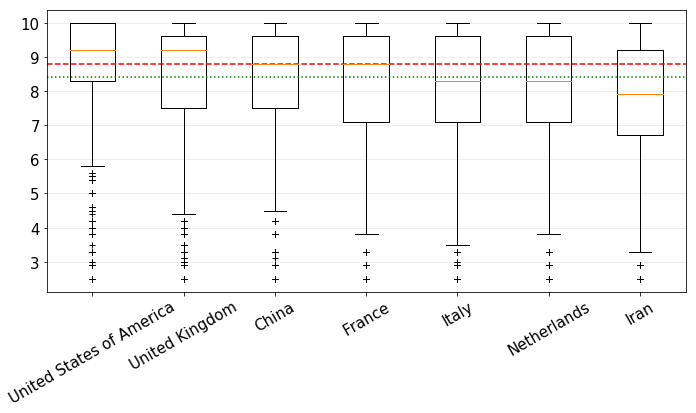

In [31]:
fig, ax = plt.subplots(figsize=(10, 6))
bp = plt.boxplot(scores)
ax.set_xticklabels(countries, rotation = 30)

plt.axhline(tot_median, color = 'red', linestyle = "--")
plt.axhline(tot_avg, color = 'green', linestyle = ":")


plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='+')
ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)
plt.tight_layout()
plt.savefig('images/nationality_bias.pdf')

## Bias distribution

In [18]:
df_bias_median.count()

101

In [19]:
pdf_median = df_bias_median.toPandas()

In [63]:
pdf_median.head()

,Reviewer_Nationality,Median,row,N,MEDIAN_POS,Tot_Median,Bias_median
0,Puerto Rico,9.6,85,169,85.0,8.8,0.8
1,Panama,9.2,59,117,59.0,8.8,0.4
2,Israel,9.2,3228,6456,3228.0,8.8,0.4
3,South Korea,9.2,525,1049,525.0,8.8,0.4
4,United States of America,9.2,17444,34887,17444.0,8.8,0.4


In [42]:
pdf_median_agg = pdf_median.groupby('Bias_median').sum()
pdf_median_agg

,Median,row,N,MEDIAN_POS,Tot_Median
Bias_median,,,,,
-0.9,39.5,1208,2414,1208.0,44.0
-0.5,290.5,48813,97603,48813.0,308.0
-0.3,17.0,3982,7963,3982.0,17.6
0.0,422.4,38866,77704,38866.0,422.4
0.4,92.0,158334,316663,158334.0,88.0
0.8,9.6,85,169,85.0,8.8


In [70]:
pdf_median.Reviewer_Nationality.unique()

array(['Puerto Rico', 'Panama', 'Israel', 'South Korea',
       'United States of America', 'Mexico', 'Canada', 'New Zealand',
       'Australia', 'Costa Rica', 'United Kingdom', 'Russia', 'Sweden',
       'Jersey', 'Philippines', 'France', 'Taiwan', 'Slovakia',
       'Argentina', 'Albania', 'Finland', 'Guernsey', 'Peru', 'China',
       'Belarus', 'Malta', 'Chile', 'Isle of Man', 'Croatia', 'Lithuania',
       'Abkhazia Georgia', 'Ireland', 'Thailand', 'Ukraine', 'Iceland',
       'Cyprus', 'Gibraltar', 'Estonia', 'Georgia', 'Montenegro',
       'Armenia', 'Trinidad and Tobago', 'Latvia', 'Macedonia',
       'Czech Republic', 'Brazil', 'Slovenia', 'Japan', 'Luxembourg',
       'Bosnia and Herzegovina', 'Poland', 'Romania', 'Bulgaria',
       'Austria', 'Serbia', 'South Africa', 'Bermuda', 'Colombia',
       'Hungary', 'Greece', 'Spain', 'Malaysia', 'Singapore', 'Turkey',
       'Iraq', 'Germany', 'Jordan', 'Sri Lanka', None, 'Belgium', 'Qatar',
       'Ghana', 'India', 'Kuwait', 'Nig

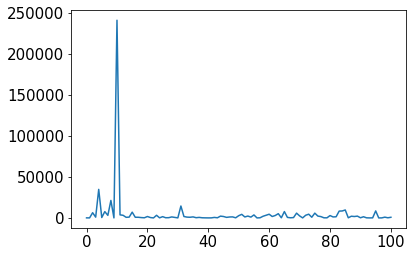

In [71]:
plt.plot( pdf_median.N)

In [46]:
pdf_median.mean()

Median            8.623762
row            2488.000000
N              4975.405941
MEDIAN_POS     2488.000000
Tot_Median        8.800000
Bias_median      -0.176238
dtype: float64

<BarContainer object of 6 artists>

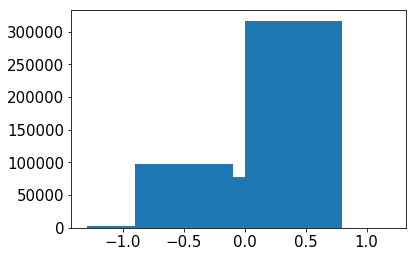

In [40]:
pdf_median_agg.index

plt.bar(pdf_median_agg.index, pdf_median_agg.N)

In [62]:
df_cleaned.groupBy('Hotel_Country', 'Hotel_Name').count().orderBy('Hotel_Country', 'count', ascending = False).show(401)

+--------------+--------------------+-----+
| Hotel_Country|          Hotel_Name|count|
+--------------+--------------------+-----+
|United Kingdom|Britannia Interna...| 4662|
|United Kingdom| Strand Palace Hotel| 4149|
|United Kingdom|Park Plaza Westmi...| 4066|
|United Kingdom|Copthorne Tara Ho...| 3509|
|United Kingdom|DoubleTree by Hil...| 3142|
|United Kingdom|Grand Royale Lond...| 2921|
|United Kingdom|Holiday Inn Londo...| 2728|
|United Kingdom|Hilton London Met...| 2547|
|United Kingdom|Intercontinental ...| 2505|
|United Kingdom|Millennium Glouce...| 2501|
|United Kingdom|Park Grand Paddin...| 2255|
|United Kingdom|Park Plaza County...| 2185|
|United Kingdom|Hilton London Wem...| 2163|
|United Kingdom| Blakemore Hyde Park| 2148|
|United Kingdom|Park Plaza London...| 2127|
|United Kingdom|DoubleTree by Hil...| 2117|
|United Kingdom|M by Montcalm Sho...| 2093|
|United Kingdom|St James Court A ...| 2030|
|United Kingdom|Park Grand London...| 2023|
|United Kingdom|Holiday Inn Lond